In [31]:
import json
import sys
import time
from pathlib import Path

import hydra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from hydra import (
    compose, 
    initialize, 
    initialize_config_dir,
    initialize_config_module
)
from hydra.utils import get_original_cwd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import (
    LatentDirichletAllocation, 
    LatentDirichletAllocation,
    NMF
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
with initialize(config_path="../config"):
    # Load config into cfg
    cfg = compose(config_name="config")

In [3]:
# Replacing hydra function
def get_original_cwd() -> str:
    return ".."

In [4]:
def read_news(config=cfg) -> list[str]:
    file_dir = Path(get_original_cwd()) / config.dataset.data_dir / config.dataset.file_name

    print("Reading file from disk")

    with open(file_dir, mode="r") as f:
        news_corpus: str = f.read()

    news_corpus: list = news_corpus.split("\n")
    for news in news_corpus:
        if news != "":
            doc = "\n".join(json.loads(news)["paras"])
            yield doc

In [5]:
all_news = read_news()
all_news = list(all_news)

Reading file from disk


In [6]:
(sys.getsizeof(all_news) / 1000) / 1024 #MB

1.2530859375

In [7]:
print(f"Number of News: {len(all_news)}")

Number of News: 152355


In [8]:
def clean_text(text: str):
    return text.replace("\n", " ") #replace newlines with spaces

In [9]:
def count_stopwords(text: str):
    """Count number of stopwords in text"""
    stopwords_set = set(stopwords.words("english"))
    text = text.lower()
    return len([word for word in text.split(" ") if word in stopwords_set])

In [10]:
clean_news = [clean_text(news) for news in all_news]
stopwords_length =  [count_stopwords(news) for news in clean_news]

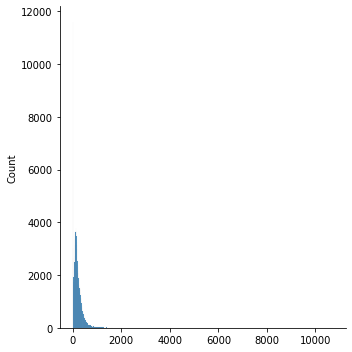

In [11]:
sns.displot(stopwords_length)
plt.show()

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    def _normalize(self, text: str) -> str:
        text = text.replace("\n", " ") #replace newlines with spaces
        stopwords_set = set(stopwords.words("english"))
        return " ".join([
            word
            for word in wordpunct_tokenize(text)
            if word not in stopwords_set
        ])
    
    def fit(self, X=None):
        return self
    
    def transform(self, corpus, y=None):
        return [self._normalize(doc) for index, doc in enumerate(corpus)]

In [33]:
with initialize(config_path="../config"):
    cfg = compose("config")

In [ ]:
pipeline = Pipeline([
    ("text_normalizer", TextNormalizer()),
    ("frequecy_bow_vectorizer", CountVectorizer()),
    ("topic_model", LatentDirichletAllocation(n_components=cfg.model.n_topics))
])

out = pipeline.fit_transform(all_news)